In [2]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
from astropy.io import fits
from matplotlib import pyplot as plt
import scipy.stats

In [3]:
def get_files_list(textfile):
    f = open(textfile,'r')
    lines = f.read().split("\n")
    return lines

#print get_files_list("testfile.txt")

## Calculating Readnoise

To estimate readnoise we pick the lowest exposure dark frames. Low exposure darks are dominated by readnoise rather than Poisson statistical noise. In this case we selected the ten 5s $\times$ 6coadd dark frames. We divide these ten darks into two groups. Each group was then median-combined and was named "master_firsthalf" and "master_secondhalf" respectively. These two "master" frames should be identical up to readnoise because by median combining 5 frames we further beat down on the statistical noise. However, by taking the median, we also reduce the readnoise by a factor of $\sqrt{5}$ which we account for in the equation below. We then subtracted the two "master" darks and call is "master_diff" to isolate the ADUs due to reading losses. This master_diff frame is then sigma-clipped to get rid of dead and hot pixels. 

Readnoise in electrons per read is then given by: 
$\sqrt{\frac{5}{2}} \times \frac{std(masterdiff) ~ \times~ gain ~\times ~ \sqrt{numreads}}{\sqrt{coadds}}$


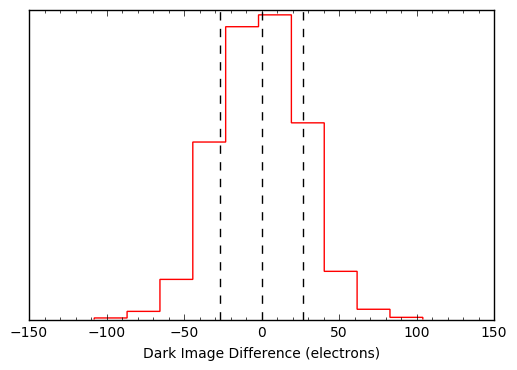

The plot shows, as expected, that the master_diff has a mean ~0


'Readnoise: ~69 electrons/read'

In [37]:
## needs flat divided list of darkframes of the same type
## need shortest exposure dark frame because read-noise dominates in this case


def calculate_readnoise(dframeslist):
    """
    Given a list of low-exposure dark frames, calculates the readnoise per read
    
    dframeslist: a list of filenames of low-exposure dark frames. Ex: ['n0021.fits.gz', 'n0022.fits.gz', 'n0023.fits.gz'...]
    
    output: float, readnoise in electrons/read
    
    """
    
    superdata = []
    
    for i in range(len(dframeslist)):
        superdata.append(fits.getdata(dframeslist[i]))
        
        
    ### get relevant info like numcoadds, numreads and ccd gain
    hdul = fits.open(dframeslist[0]) 
    hdr = hdul[0].header  
    
    coadds = hdr['COADDS']
    numreads = hdr["MULTISAM"]
    gain = hdr['GAIN']  ## electrons/ADU
    
    
    
    ### do a random shuffle
    import random
    random.shuffle(superdata)
    
    
    
    ### divide the dark frames into two sets
    firsthalf = np.array(superdata[:len(superdata)/2])
    secondhalf = np.array(superdata[len(superdata)/2 : ])

    
    ### median combine each set
    masterfirsthalf = np.median(firsthalf, axis=0)
    mastersecondhalf = np.median(secondhalf, axis=0)
    
    
  
    ### subtract the two master frames
    masterdiff = masterfirsthalf - mastersecondhalf
    
    
    
    ### flatten the array into one dimension
    flat_masterdiff = np.ndarray.flatten(masterdiff)
  
    
    ### sigma-clip the masterdiff to get rid of dead and hot pixels
    clip_flat_masterdiff, low, high = scipy.stats.sigmaclip(flat_masterdiff)

    
    
    ### plot the resulting histogram
    plt.hist(clip_flat_masterdiff*gain, color="r", histtype="step" )
    plt.yticks([])
    plt.xlabel("Dark Image Difference (electrons)")
    plt.axvline(x=np.median(clip_flat_masterdiff*gain), ls="--", c="k")
    plt.axvline(x=np.median(clip_flat_masterdiff*gain) - np.std(clip_flat_masterdiff*gain), ls="--", c="k")
    plt.axvline(x=np.median(clip_flat_masterdiff*gain) + np.std(clip_flat_masterdiff*gain), ls="--", c="k")
    plt.minorticks_on()
    plt.show()
    
    print ("The plot shows, as expected, that the master_diff has a mean ~0")
    
    ### calculate readnoise
    readnoise = np.std(clip_flat_masterdiff)*gain*np.sqrt(numreads)*np.sqrt(5/2.)/(np.sqrt(coadds))
    
    ### print readnoise
    #print ("readnoise: ~" + str(int(readnoise)) + " electrons/read")
    
    return readnoise


"Readnoise: ~" + str(int(calculate_readnoise(get_files_list("testfile.txt")))) + " electrons/read"

    
    